## 🔰*============ Summary Overview =============*🔰
  ### 🔑 To reduce training times **be sure that runtime is set to use GPU**
  #### &emsp; (menu) Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU
  * Useful resourse for understanding Convolutional Neural Networks: [CNN Explainer](https://poloclub.github.io/cnn-explainer/)

### 📔***Notebook: 03a_CVandCNN_Intro***
  1. **Retrieve Dataset**
    * Data is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) that include only images of Pizza & Steak
    * Link to this subset is provided by [Zero-to-Mastery](https://github.com/mrdbourke/tensorflow-deep-learning).
  2.  **Visualize the Dataset**
    * view 9 random images of steak
    * view 9 random images of pizza

  3. **Preprocess Dataset & Data Augmentation** 
    * use [TensorFlow ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
    * Normalize data on interval (0,1)
    * Split data into a train, validation, and test sets
    * Using Data Augmentation to overcome overfitting training data.
    * *shear, zoom, shift, and flip*.

## 📔***Notebook: 03b_CVandCNN_Build Models***
  4. **Build Models**
    * Build a very simple NN using Dense Layers as reference
    * Build a simple CNN to compare performance
    * Build a a CNN using the **[Tiny VGG architecture](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)**
  

## 📔***Notebook: 03c_CVandCNN_Viualize_Layer_Outputs***
  5. **Visualize CNN Filter Patterns**
    * Render an image after processing through the first CNN Layer.
    * Show the resulting Convolution for each output filter.
    * Display original image along side for reference.

## 🔰*============ Visualize CNN Filter Views =============*🔰

  * Visualize Filter view of a **Pizza** by Layer
  * Visualize Filter view of a **Steak** by Layer

In [ ]:
#@title Helper Functions: **show_image_cnn_filter_view, get_batch, get_outputs**

def _make_figure(layer_name,depth,shape):
  """
    Create a matplotlib figure and add a title
  """
  fig = plt.figure(figsize=(18,6),tight_layout={'pad':1.5,'h_pad':1.5,'w_pad':1.5})
  fig.suptitle(f'Layer {layer_name}, Depth {depth}, Shape {shape}',
               fontsize=15,color='red',
               x=0.36,
               y=1.025)

  return fig


def _make_axes(figure):
  """
    Will set up layout of axes on figure:
    Left: 10 axes for CNN filters, 
    Right: 4 axes (combined) for original image

           Left                 Right       
    fax0 fax1 fax2 fax3 fax4 | Img Img
    - - - - - - - - - - - - -| 
    fax5 fax6 fax7 fax8 fax9 | Img Img

  """
  gs = GridSpec(2,7,figure=figure)
  Laxes = []
  Rax = figure.add_subplot(gs[:,5:])

  for row in range(0,2):
    for col in range(0,5):
      ax = figure.add_subplot(gs[row,col])
      Laxes.append(ax)

  return Laxes,Rax  


def _display_original_image(image,ax,label):
  """
    Displays input image for reference. 
  """
  ax.imshow(image)
  ax.set_xticks([])
  ax.set_yticks([])
  text = 'Steak' if int(label) else 'Pizza'
  ax.set_title(text,fontsize=20)    

def _format_filter_ax(ax,idx):
  """
    reduce clutter on filter image axes by removing x-axis, and y-axis ticks. 
  """
  ax.set_title(f'filter {idx}',fontsize=10)
  ax.set_xticks([]) 
  ax.set_yticks([])

def _get_min_max(output):
  """
    used to provide consistant color scaling accross filter images.
    finds the global min, max values for all filter views. 
  """
  if 'dense' not in output.layer_name:
    min = tf.reduce_min(output).numpy()
    max = tf.reduce_max(output).numpy()
  else:
    min = None
    max = None
  return min,max

def _get_dense_layer_view(outputs,layers,layer_idx):
    """
      CNNs & Maxpools have a 'Filter View' however,
      Dense layers have a 'Neuron View' and need
      to be calculated differently. 
    """
    #--Search for the closest Non-Flattened layer
    idx = layer_idx
    while idx > 0:
      idx -= 1
      if len(outputs[idx].shape) > 2:
        reshape_dense_view = outputs[idx].shape
        break

    #--Calculate Dense Layer Neuron View:
    dense_weights = tf.squeeze(layers[layer_idx].weights[0])
    output = np.reshape(outputs[layer_idx-1] * dense_weights,reshape_dense_view)
    output = tf.constant(output)

    #--Store information to be held for axes & figure formatting
    output.layer_name = outputs[layer_idx].layer_name
    output.layer_idx = layer_idx

    return output

def show_image_cnn_filter_view(outputs,images,labels,layers,layer_idx,img_idx,cmap):
  """
    Displays the results of each filter after processing an image,
    along with the original image.
  """
  #----Setup:
  output = outputs[layer_idx]
  image = images[img_idx,:,:,:]
  im_shape = output.shape[1:-1]
  is_dense = False

  if 'dense' in output.layer_name:
    output = _get_dense_layer_view(outputs,layers,layer_idx)
    im_shape = output.shape[1:-1]

  fig = _make_figure(layer_name=output.layer_name,
                     depth=output.layer_idx,
                     shape=im_shape)
  
  Laxes,Rax = _make_axes(fig)

  #------------- Display Right Side Image
  _display_original_image(image=image,
                          ax=Rax,
                          label=labels[img_idx])
  
  #------------- Display Left Side Images:
  #--Get Min,Max values for consistent color scaling
  min_val,max_val = _get_min_max(output)
  
  #--Display filter 'view'
  for filter_idx,ax in enumerate(Laxes):
    filter_view = output[img_idx,:,:,filter_idx]
    img = ax.imshow(filter_view,
                    cmap=cmap,
                    vmin=min_val,
                    vmax=max_val)
    
    _format_filter_ax(ax=ax,
                      idx=filter_idx)



def get_batch(data_batches,batch_idx):
  data_batches.reset()
  for bidx, data in enumerate(data_batches):
    batch_images, batch_labels = data

    if bidx == batch_idx:
      break

  """
  #--Rest total_batches_seen, this is a factor in generating batches.
     Otherwise a new random set of images make up the same 'batch'
     and passing the same batch_idx will result in a different image. 
  """
  data_batches.total_batches_seen -= batch_idx + 1 #<--- This allows repeatability!  
  
  return batch_images, batch_labels


def get_outputs(batch_images,layers):
  """
    Will save the outputs of each layer. 
  """
  #-- Setup
  outputs = []
  output = batch_images
  for Lidx,layer in enumerate(layers):
    output = layer(output)         #-- Replaces previous layer output, with current layer output.   
    output.layer_name = layer.name #-- Label Layer Output
    output.layer_idx = Lidx
    outputs.append(output)         #-- Add to list
#    if Lidx == layer_idx:
#     break

  return outputs 

In [ ]:
print(f'Maximum Batch Index: {len(train_data)-1}')

Maximum Batch Index: 37


In [ ]:
#--- Will retrieve a batch of 32 images & Labels
batch_images, batch_labels= get_batch(data_batches=train_data,
                                      batch_idx=0)             #Batch Index for the purposes of Visuals below batches are static ()

In [ ]:
#--- For a CNN this is the POST processing (filter) view, For a Dense Layer it is a PRE processing (weights) view
outputs = get_outputs(batch_images=batch_images,
                      layers=layers_vgg)                 

## 🔰*============ Visualize Pizza =============*🔰
  * VGG model
  * 6 layers total
  * Flatten layer (layer index 6) is skipped

In [ ]:
#steak: 7
#pizza 20,22,23,27,28

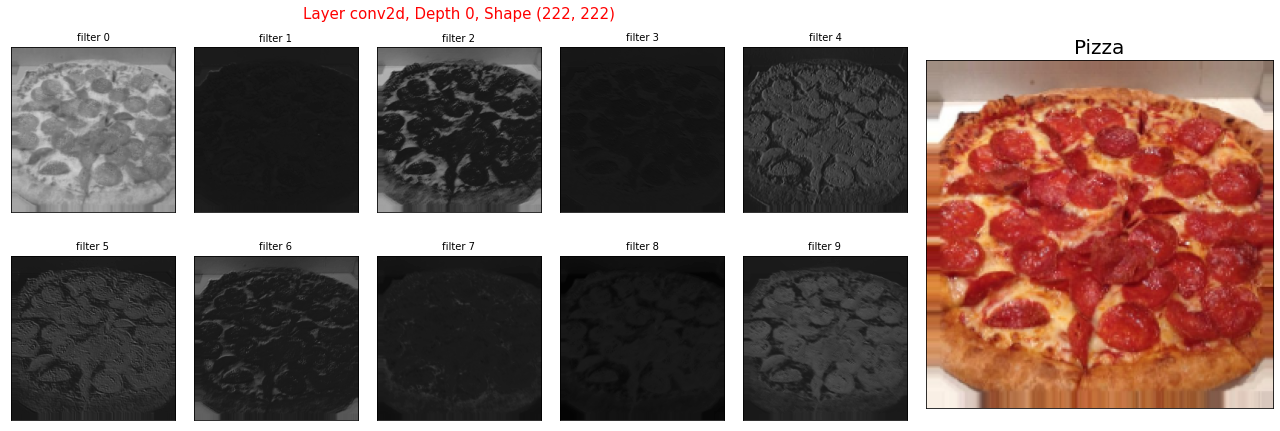

In [ ]:
idx_pizza = 27
color_scale = 'Greys_r'
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 0,
                           img_idx=idx_pizza,
                           cmap=color_scale)

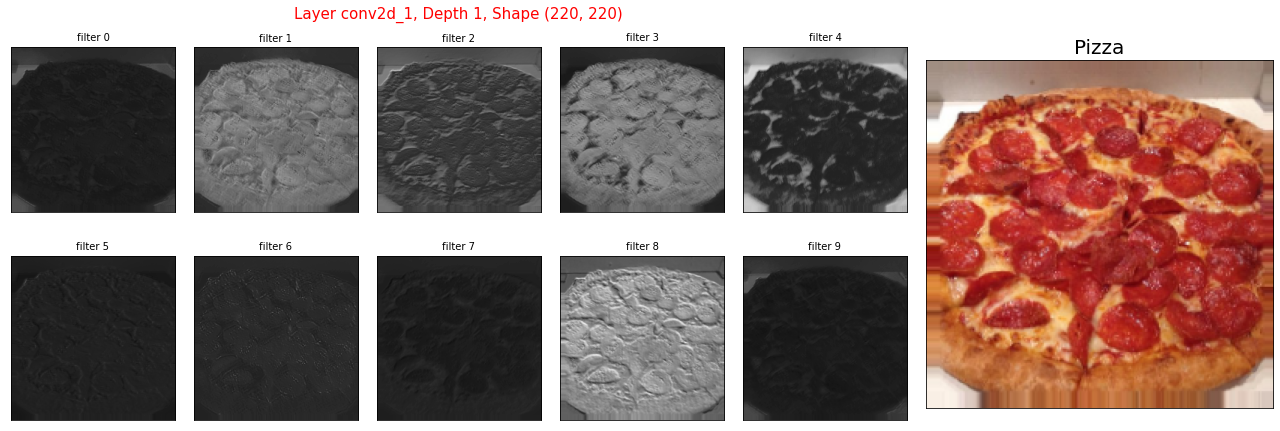

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 1,
                           img_idx=idx_pizza,
                           cmap=color_scale)

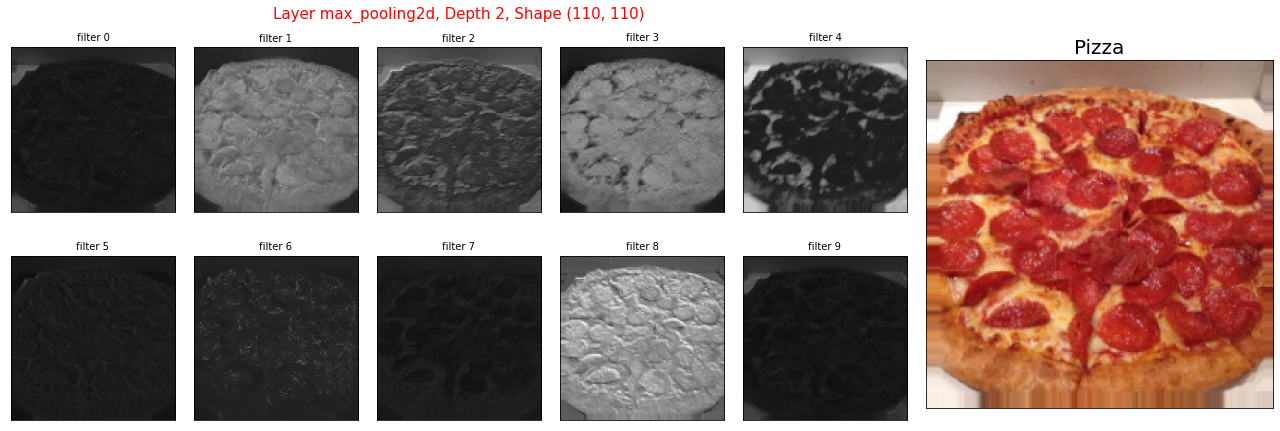

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 2,
                           img_idx=idx_pizza,
                           cmap=color_scale)

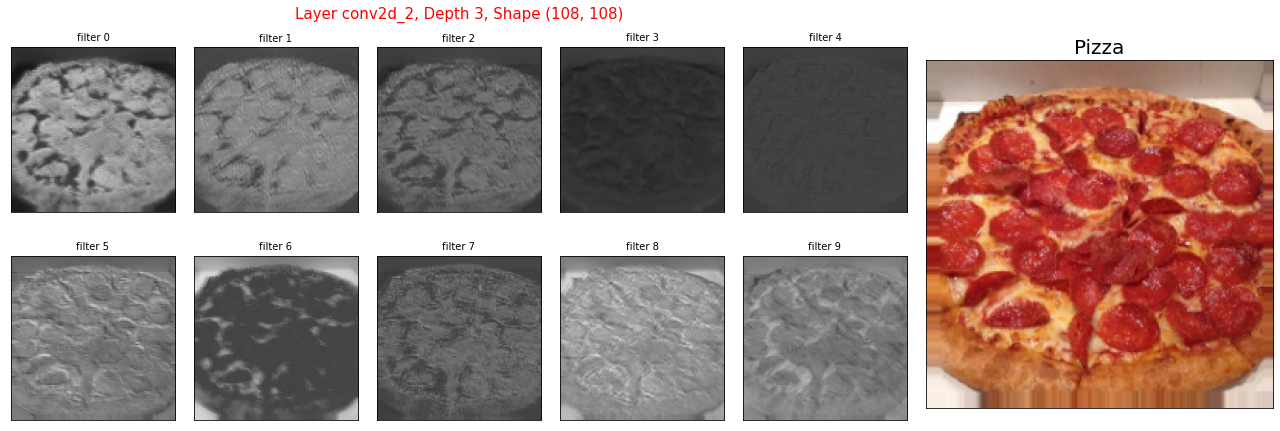

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 3,
                           img_idx=idx_pizza,
                           cmap=color_scale)

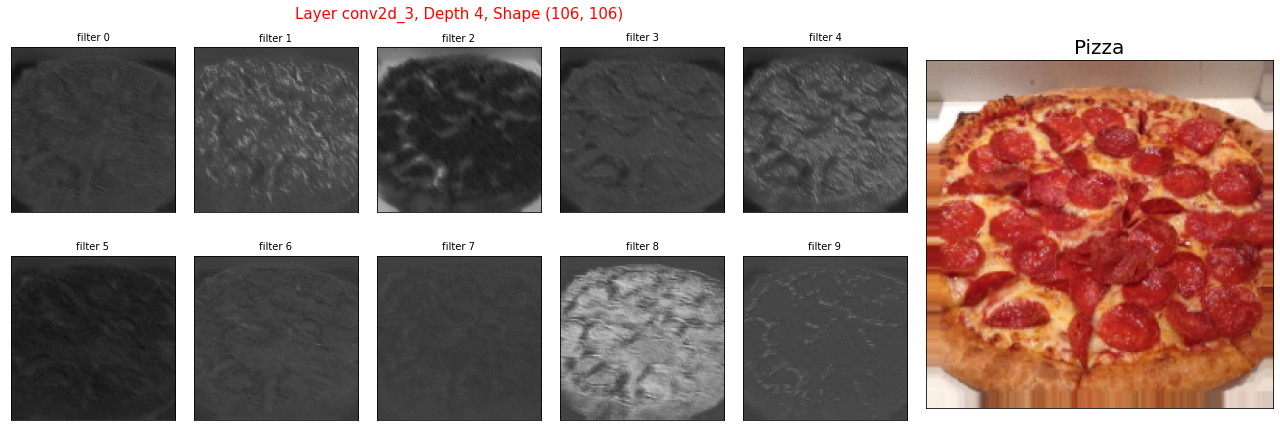

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 4,
                           img_idx=idx_pizza,
                           cmap=color_scale)

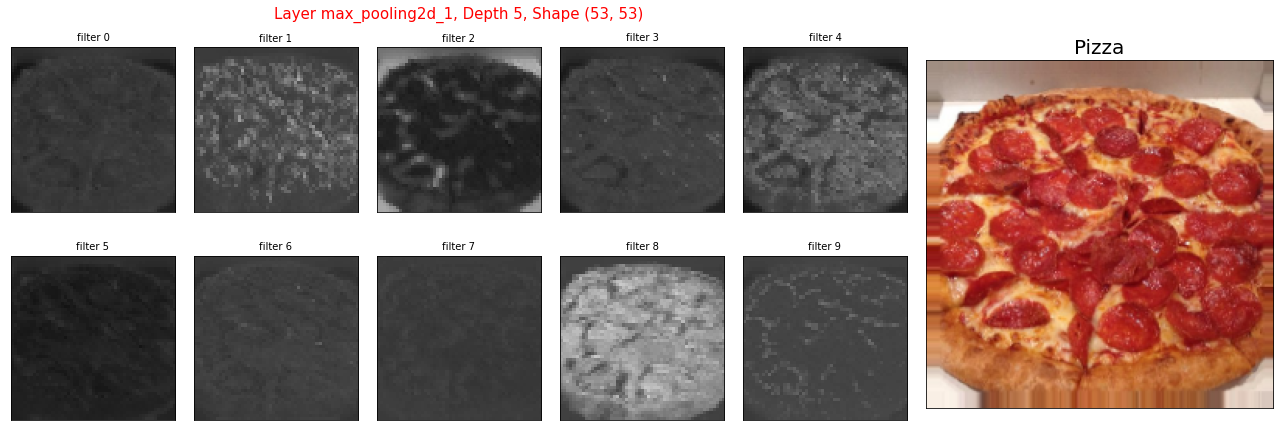

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 5,
                           img_idx=idx_pizza,
                           cmap=color_scale)

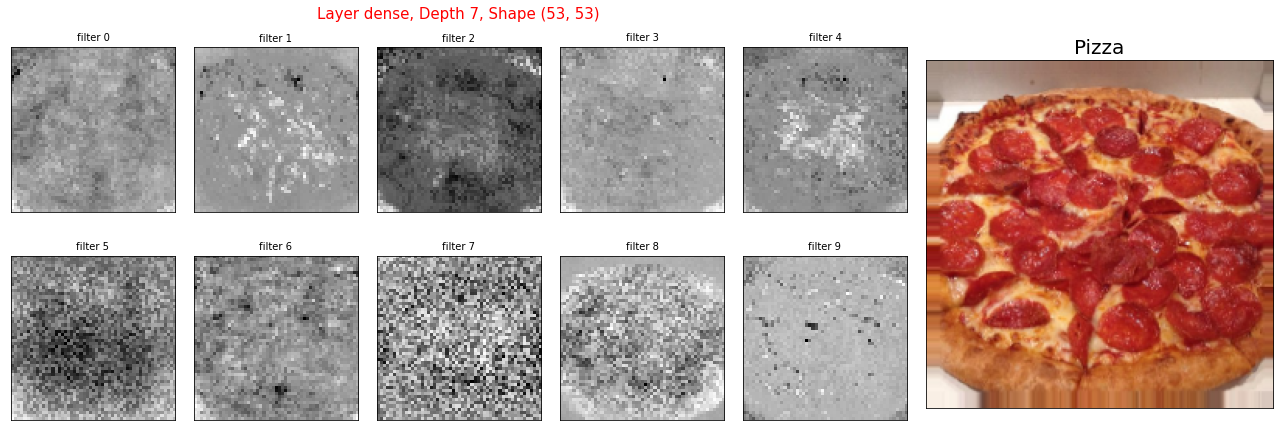

In [ ]:
show_image_cnn_filter_view(outputs=outputs,
                           images=batch_images,
                           labels= batch_labels,
                           layers=layers_vgg,
                           layer_idx = 7,
                           img_idx=idx_pizza,             
                           cmap=color_scale) 

#📔 Continue to notebook: [03c_CVandCNN_Visualize_Layer_Outputs_Steak](https://github.com/delta2echo/tensorflow_portfolio/blob/main/03c_CVandCNN_Visualize_Layer_Outputs_Steak.ipynb)